### Black Scholes Model

In [1]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import datetime as dt
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import yfinance as yf

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from matplotlib.ticker import FuncFormatter

In [2]:
def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
def bs_put(S,K,T,r,sigma):
    return K*exp(-r*T)-S*bs_call(S,K,T,r,sigma)

In [3]:
from datetime import datetime, date
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import yfinance as yfin

In [4]:
stock_call = ['TSLA']   #select your underlying stock here
expiry_call = '4-16-2025'   #enter expiry date of call here
strike_price_call = 370   #enter strike price of call

stock_put = ['UPS'] #select your underlying stock here
expiry_put = '5-16-2025' #enter expiry date of put here
strike_price_put = 1120   #enter strike price of put
riskfree_rate = 0.5   #enter riskfree rate

In [5]:
#Black Scholes Model of call

today = datetime.now()
one_year_ago = today.replace(year=today.year-1)

yfin.pdr_override()

df = pdr.get_data_yahoo(stock_call, one_year_ago, today)
df = df.sort_values(by="Date")
df = df.dropna()
df = df.assign(close_day_before=df.Close.shift(1))
df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)

sigma = np.sqrt(252) * df['returns'].std()
uty = pdr.get_data_yahoo("^TNX", one_year_ago, today)['Close'].iloc[-1]/100
lcp = df['Close'].iloc[-1]
t = (datetime.strptime(expiry_call, "%m-%d-%Y") - datetime.utcnow()).days / 365

print('The Option Price is: ', bs_call(lcp, strike_price_call, t, uty, sigma))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
The Option Price is:  34.04616809394509


In [6]:
def call_implied_volatility(Price, S, K, T, r):
    sigma = 0.01
    while sigma < 1:
        Price_implied = S * \
            norm.cdf(d1(S, K, T, r, sigma))-K*exp(-r*T) * \
            norm.cdf(d2(S, K, T, r, sigma))
        if Price-(Price_implied) < 0.01:
            return sigma
        sigma += 0.01
    return "Not Found"

def put_implied_volatility(Price, S, K, T, r):
    sigma = 0.01
    while sigma < 1:
        Price_implied = K*exp(-r*T)-S+bs_call(S, K, T, r, sigma)
        if Price-(Price_implied) < 0.01:
            return sigma
        sigma += 0.01
    return "Not Found"

print("Implied Volatility of call is: " +
      str(100 * call_implied_volatility(bs_call(lcp, strike_price_call, t, uty, sigma,), lcp, strike_price_call, t, uty,)) + " %")


Implied Volatility of call is: 67.00000000000004 %


In [47]:
#Black Scholes Model of put

df_put = pdr.get_data_yahoo(stock_put, one_year_ago, today)['Close']
t = (datetime.strptime(expiry_put, "%m-%d-%Y") - datetime.utcnow()).days / 365
print('The Option Price is: ', bs_put(lcp, strike_price_put, t, uty, sigma))

df_put.head()

[*********************100%***********************]  1 of 1 completed


Date
2022-04-18    187.160004
2022-04-19    190.690002
2022-04-20    190.429993
2022-04-21    188.800003
2022-04-22    187.149994
Name: Close, dtype: float64

In [32]:
print("Implied Volatility of put is: " +
      str(100 * put_implied_volatility(bs_put(lcp, strike_price_put, t, uty, sigma,), lcp, strike_price_put, t, uty,)) + " %")


Implied Volatility of put is: 1.0 %


In [9]:
def call_delta(S,K,T,r,sigma):
    return norm.cdf(d1(S,K,T,r,sigma))
def call_gamma(S,K,T,r,sigma):
    return norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*sqrt(T))
def call_vega(S,K,T,r,sigma):
    return 0.01*(S*norm.pdf(d1(S,K,T,r,sigma))*sqrt(T))
def call_theta(S,K,T,r,sigma):
    return 0.01*(-(S*norm.pdf(d1(S,K,T,r,sigma))*sigma)/(2*sqrt(T)) - r*K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma)))
def call_rho(S,K,T,r,sigma):
    return 0.01*(K*T*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma)))
    
def put_delta(S,K,T,r,sigma):
    return -norm.cdf(-d1(S,K,T,r,sigma))
def put_gamma(S,K,T,r,sigma):
    return norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*sqrt(T))
def put_vega(S,K,T,r,sigma):
    return 0.01*(S*norm.pdf(d1(S,K,T,r,sigma))*sqrt(T))
def put_theta(S,K,T,r,sigma):
    return 0.01*(-(S*norm.pdf(d1(S,K,T,r,sigma))*sigma)/(2*sqrt(T)) + r*K*exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma)))
def put_rho(S,K,T,r,sigma):
    return 0.01*(-K*T*exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma)))


In [10]:
print(call_delta(lcp, strike_price_call, t, uty, sigma))
print(call_gamma(lcp, strike_price_call, t, uty, sigma))
print(call_vega(lcp, strike_price_call, t, uty, sigma))
print(call_theta(lcp, strike_price_call, t, uty, sigma))
print(call_rho(lcp, strike_price_call, t, uty, sigma))
print(put_delta(lcp, strike_price_put, t, uty, sigma))
print(put_gamma(lcp, strike_price_put, t, uty, sigma))
print(put_vega(lcp, strike_price_put, t, uty, sigma))
print(put_theta(lcp, strike_price_put, t, uty, sigma))
print(put_rho(lcp, strike_price_put, t, uty, sigma))

0.43428218542267183
0.0022173792156576395
1.0498078212047346
-0.18391560804273382
0.9310562189596969
-0.9065926848651864
0.0009405763560347729
0.44531147763676465
0.29598928369101435
-21.377791659731944


### Monte Carlo Simulation

In [19]:
# Yearly returns for individual companies
#test = pdr.get_data_yahoo(stocks, one_year_ago, today)['Adj Close']
#ind_er = test.resample('Y').last().pct_change().mean()
#weights = np.array([0.5,0.5])
#cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()

#print("mean return\n",ind_er)
#print ("cov_matrix",cov_matrix)

[*********************100%***********************]  10 of 10 completed


In [35]:
# import data
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, one_year_ago, today)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

In [36]:
stockList = ['TSLA', 'NKE', 'KO', 'PEP','GE','IBM']
stocks = [stock for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)

meanReturns, covMatrix = get_data(stocks, startDate, endDate)

weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

[*********************100%***********************]  6 of 6 completed


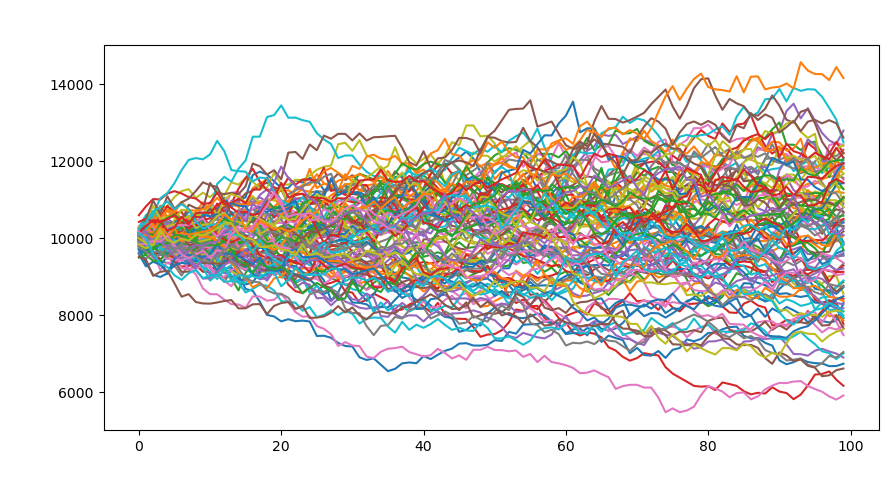

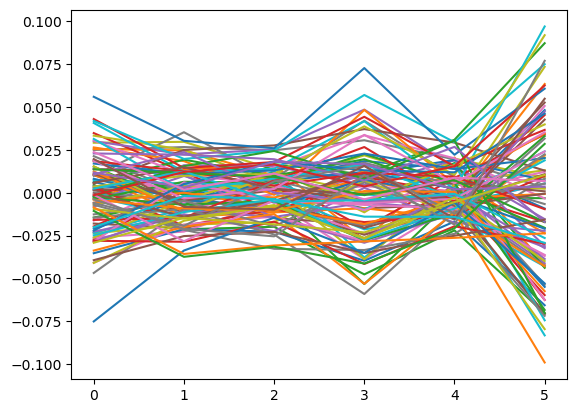

In [37]:
mc_sims = 100 # number of simulations，计算expiration date到现在的天数, 增加’当天日期‘的变量
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000#call+put+stock value

for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio #累计乘积，dailyreturns的倍数（天数），时间点下的portfolio value，

font = {'family': 'serif',
        'color':  'white',
        'weight': 'normal',
        'size': 25,
        }

plt.figure(figsize=(10,5))
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)',  fontdict=font)
plt.xlabel('Days',  fontdict=font)
plt.title('Monte Carlo simulation of a stock portfolio',  fontdict=font)
plt.show()
plt.plot(dailyReturns)


### VaR,CVaR

In [38]:
def mcVaR(returns, alpha):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [39]:
# You will probably want to print results!!
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, 5)
CVaR = initialPortfolio - mcCVaR(portResults, 5)

print('VaR ${:,.2f}'.format(VaR,2))
print('CVaR ${:,.2f}'.format(CVaR,2))

VaR $3,003.70
CVaR $3,541.03


In [48]:
#Annualized Return
mu = expected_returns.mean_historical_return(df_portfolio)
#Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df_portfolio)
#Max Sharpe Ratio - Tangent to the EF
from pypfopt import objective_functions, base_optimizer
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef.max_sharpe() 
#May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)

OrderedDict([('Call', 0.0), ('Put', 0.0), ('GE', 1.0), ('IBM', 0.0), ('KO', 0.0), ('NKE', 0.0), ('PEP', 0.0), ('TSLA', 0.0)])


In [47]:
#VaR Calculation
ticker_rx2 = []
#Convert Dictionary to list of asset weights from Max Sharpe Ratio Portfolio
sh_wt = list(sharpe_pwt.values())
sh_wt=np.array(sh_wt)

In [42]:
#convert the stock prices to a cumulative return(holding period returns (HPR)for this project)
thelen = len(stockList)
for a in range(thelen):
  ticker_rx = df_stocks[[stockList[a]]].pct_change()
  ticker_rx = (ticker_rx+1).cumprod()
  ticker_rx2.append(ticker_rx[[stockList[a]]])
ticker_final = pd.concat(ticker_rx2,axis=1)
ticker_final   

,TSLA,NKE,KO,PEP,GE,IBM
Date,,,,,,
2022-04-18,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-19,1.023758,1.041176,1.009776,1.014552,1.016593,1.023619
2022-04-20,0.973026,1.032211,1.023588,1.029633,1.011062,1.096299
2022-04-21,1.004471,1.029097,1.027467,1.025936,1.014602,1.108425
2022-04-22,1.000757,0.980552,1.012570,1.010151,0.985288,1.095744
...,...,...,...,...,...,...
2023-04-11,0.557976,0.936717,0.971136,1.073348,1.330738,1.033685
2023-04-12,0.539306,0.939451,0.972843,1.071236,1.333430,1.018784
2023-04-13,0.555318,0.960495,0.979981,1.081915,1.336264,1.013712


In [46]:
#pick out the latest HPR of each asset and multiply the returns with the calculated asset weights
pret = []
pre1 = []
price =[]
for x in range(thelen):
  pret.append(ticker_final.iloc[[-1],[x]])
  price.append((df_stocks.iloc[[-1],[x]]))
pre1 = pd.concat(pret,axis=1)
pre1 = np.array(pre1)
price = pd.concat(price,axis=1)
varsigma = pre1.std()
ex_rtn=pre1.dot(sh_wt)
print('The weighted expected portfolio return for selected time period is'+ str(ex_rtn))
#ex_rtn = (ex_rtn)**0.5-(1) #Annualizing the cumulative return (will not affect outcome)
price=price.dot(sh_wt) #Calculating weighted value
print(ex_rtn, varsigma, price)

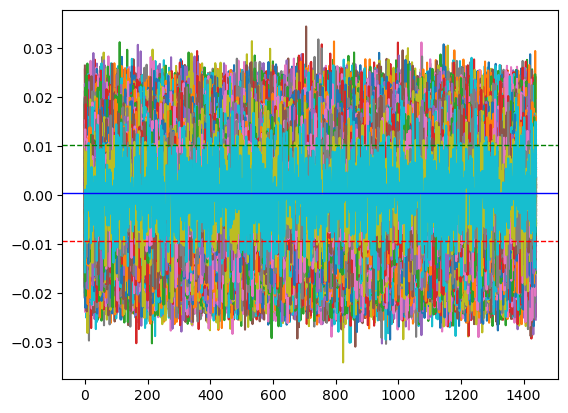

In [26]:
from scipy.stats import norm
import math
Time=1440 #No of days(steps or trading days in this case)
lt_price=[]
final_res=[]
for i in range(10000): #10000 runs of simulation
  daily_returns=(np.random.normal(ex_rtn/Time,varsigma/math.sqrt(Time),Time))
  plt.plot(daily_returns)
plt.axhline(np.percentile(daily_returns,5), color='r', linestyle='dashed', linewidth=1)
plt.axhline(np.percentile(daily_returns,95), color='g', linestyle='dashed', linewidth=1)
plt.axhline(np.mean(daily_returns), color='b', linestyle='solid', linewidth=1)
plt.show()

In [27]:
print(np.percentile(daily_returns,5),np.percentile(daily_returns,95)) #VaR - Minimum loss of 5.7% at a 5% probability, also a gain can be higher than 15% with a 5 % probability
pvalue = 1000 #portfolio value
print('$Amount required to cover minimum losses for one day is ' + str(pvalue* - np.percentile(daily_returns,5)))

-0.009386618558060562 0.010364517771170194
$Amount required to cover minimum losses for one day is 9.386618558060562


In [22]:
history

from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import datetime as dt
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import yfinance as yf

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from matplotlib.ticker import FuncFormatter
def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
def bs_put(S,K,T,r,sigma):
    return K*exp(-r*T)-S*bs_call(S,K,T,r,sigma)
from datetime import datetime, date
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import yfinance as yfin
stock_call = ['TSLA']   #select your underlying stock here
expiry_call = '4-16